<h1 style="font-size:40px;"><center>Exercise I:<br> Multi-layer perceptrons
for classification and regression problems.
</center></h1>


## Dataset

### syn1 - syn3
Three different synthetic classification problems will be used. They are all 2D binary classification problems which allows for an easy visual inspection of the different classes and the decision boundary implemented by the network. They are called *syn1, syn2* and *syn3*. Each of these datasets are generated "on the fly" each time. They come from various normal distributions. Since they are generated using random numbers it means that each time you generate the data it will be slightly different from next time. You can control this by having a fixed *seed* to the random number generator. The cell "PlotData" will plot these datasets.

### regr1
There is also a synthetic regression problem, called *regr1*. It has 6 inputs (independent variables) and one output variable (dependent variable). It is generated according to the following formula:  

$\qquad d = 2x_1 + x_2x_3^2 + e^{x_4} + 5x_5x_6 + 3\sin(2\pi x_6) + \alpha\epsilon$  
    
where $\epsilon$ is added normally distributed noise and $\alpha$ is a parameter controlling the size of the added noise. Variables $x_1,...,x_4$ are normally distrubuted with zero mean and unit variance, whereas $x_5, x_6$ are uniformly distributed ($[0,1]$). The target value $d$ has a non-linear dependence on ***x***.

### Spiral data
This is the "famous" spiral dataset that consists of two 2-D spirals, one for each class. The perfect classification boundary is also a spiral. The cell "PlotData" will plot this dataset.

### Japanese vowels dataset
*This data set is taken from the UCI Machine Learning Repository [https://archive.ics.uci.edu/ml/datasets/Japanese+Vowels].* In short, nine male speakers uttered two Japanese vowels /ae/ successively. For each utterance, a discrete times series was produced where each time point consists of 12 (LPC cepstrum) coefficients. The length of each time series was between 7-29. 
Here we treat each point of the time series as a feature (12 inputs). In total we have 9961
data points which then has been divided into 4274 for training, 2275 for validation and 3412 for test. The original data files are provided as *ae.train* and *ae.test*. The task is now based on a single sample value of one of the speakers, determine which speaker it was. This is, in summary, a 9-class classification problem with 12 input values for each case.

In [137]:
import os
os.environ['KERAS_BACKEND']='tensorflow'

import numpy as np
import scipy as sp
import tensorflow as tf
import random as rn

import keras
from keras import backend as K
from keras.layers import Dense, Input
from keras.models import Model
from keras import metrics, regularizers, optimizers  

from sklearn.metrics import *

import matplotlib.pyplot as plt
import matplotlib as mpl


# The size of the plots.
mpl.rcParams['figure.figsize'] = (5,5)


# To have the plots inside the notebook "inlin" should be True. If "inlin" = False, then plots will pop out of the notebook
inlin = True # True/False
if inlin:
    %matplotlib inline
else:
    %matplotlib 


In [138]:
def pipline(inp_dim,
            n_nod,
            act_fun = 'relu',# 'linear','tanh','sigmoid'
            out_act_fun = 'sigmoid',#'softmax'
            opt_method = 'Adam',# 'SGD','Nadam','RMSprop'
            cost_fun = 'binary_crossentropy',# 'categorical_crossentropy'  ,'mean_squared_error'
            lr_rate = 0.01, 
            lambd = 0.0, 
            num_out = None):
    
    lays = [inp_dim] + n_nod
    
    main_input = Input(shape=(inp_dim,), dtype='float32', name='main_input')
    
    X = main_input
    for nod in n_nod:
        X = Dense(nod, 
                  activation = act_fun,
                  kernel_regularizer=regularizers.l2(lambd))(X)
        
    output = Dense(num_out, activation = out_act_fun )(X)
    
    #method = getattr(tf.keras.optimizers, opt_method)  #Changed your code because didn´t work and imported keras optimizers instead of tensorflow 
    
    method = getattr(keras.optimizers, opt_method)
    #from keras.optimizers import adam

    model =  Model(inputs=[main_input], outputs=[output])
    model.compile(optimizer = method(lr = lr_rate),
                  loss = cost_fun)
                  #metrics=['accuracy', 'mse'])   
    
    return model



In [139]:
#Dataset Cell
def syn1(N):
    """ data(samples, features)"""
    
    global seed
    
    data = np.empty(shape=(N,2), dtype = np.float32)  
    tar = np.empty(shape=(N,), dtype = np.float32) 
    N1 = int(N/2)
  
    data[:N1,0] = 4 + np.random.normal(loc=.0, scale=1., size=(N1))
    data[N1:,0] = -4 + np.random.normal(loc=.0, scale=1., size=(N-N1))
    data[:,1] = 10*np.random.normal(loc=.0, scale=1., size=(N))
    
    
    data = data / data.std(axis=0)
    
    # Target
    tar[:N1] = np.ones(shape=(N1,))
    tar[N1:] = np.zeros(shape=(N-N1,))
    
    # Rotation
    theta = np.radians(30)
    c, s = np.cos(theta), np.sin(theta)
    R = np.array([[c,-s],[s,c]]) # rotation matrix
    data = np.dot(data,R) 
    
    return data,tar


def syn2(N):
    """ data(samples, features)"""
    
    global seed
     
    data = np.empty(shape=(N,2), dtype = np.float32)  
    tar = np.empty(shape=(N,), dtype = np.float32) 
    N1 = int(N/2)

    # Positive samples
    data[:N1,:] = 0.8 + np.random.normal(loc=.0, scale=1., size=(N1,2))
    # Negative samples 
    data[N1:,:] = -.8 + np.random.normal(loc=.0, scale=1., size=(N-N1,2))
    
    
    # Target
    tar[:N1] = np.ones(shape=(N1,))
    tar[N1:] = np.zeros(shape=(N-N1,))

    return data,tar


def syn3(N):
    """ data(samples, features)"""

    global seed
    
    data = np.empty(shape=(N,2), dtype = np.float32)  
    tar = np.empty(shape=(N,), dtype = np.float32) 
    N1 = int(2*N/3)
    
    # disk
    teta_d = np.random.uniform(0, 2*np.pi, N1)
    inner, outer = 2, 5
    r2 = np.sqrt(np.random.uniform(inner**2, outer**2, N1))
    data[:N1,0],data[:N1,1] = r2*np.cos(teta_d), r2*np.sin(teta_d)
        
    #circle
    teta_c = np.random.uniform(0, 2*np.pi, N-N1)
    inner, outer = 0, 3
    r2 = np.sqrt(np.random.uniform(inner**2, outer**2, N-N1))
    data[N1:,0],data[N1:,1] = r2*np.cos(teta_c), r2*np.sin(teta_c)
    
    # Normalization
    #data = data - data.mean(axis=0)/data.std(axis=0)

    tar[:N1] = np.ones(shape=(N1,))
    tar[N1:] = np.zeros(shape=(N-N1,))
    
    return data, tar


def regr1(N, v=0):
    """ data(samples, features)"""

    global seed

    data = np.empty(shape=(N,6), dtype = np.float32)  
    
    uni = lambda n : np.random.uniform(0,1,n)
    norm = lambda n : np.random.normal(0,1,n)
    noise =  lambda  n : np.random.normal(0,1,n)
    
    
    for i in range(4):
        data[:,i] = norm(N)
    for j in [4,5]:
        data[:,j] = uni(N)
    
    tar =   2*data[:,0] + data[:,1]* data[:,2]**2 + np.exp(data[:,3]) + \
            5*data[:,4]*data[:,5]  + 3*np.sin(2*np.pi*data[:,5])
    std_signal = np.std(tar)
    tar = tar + v * std_signal * noise(N)
        
    return data, tar

def spiral():
    tmp = np.loadtxt("spiral.dat")
    data, tar = tmp[:, :2], tmp[:, 2]

    return data, tar

def vowels():
    
    def pre_proc(file_name):
        block = []
        x = []
    
        with open(file_name) as file:
            for line in file:    
                if line.strip():
                    numbers = [float(n) for n in line.split()]
                    block.append(numbers)
                else:
                    x.append(block)
                    block = []
                
        ################################
        x = [np.asarray(ar) for ar in x]    
        return x

    x_train = pre_proc('ae.train')
    x_test = pre_proc('ae.test')

    
    ############## LABELS###########
    chunk1 = list(range(30,270, 30))
    y_train = []
    person = 0

    for i, block in enumerate(x_train):
        if i in chunk1:
            person += 1
        y_train.extend([person]*block.shape[0])
        
    chunk2 = [31,35,88,44,29,24,40,50,29]
    chunk2 = np.cumsum(chunk2)
    y_test = []
    person = 0
    for i, block in enumerate(x_test):
        if i in chunk2:
            person += 1
        y_test.extend([person]*block.shape[0])

    x_train = np.vstack(x_train)
    x_test = np.vstack(x_test)
    
    ## Split into train, validation and test
    num_classes = 9
    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_test = keras.utils.to_categorical(y_test, num_classes)

    from sklearn.model_selection import train_test_split

    x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.4, random_state=42)

    return x_train, y_train, x_val, y_val, x_test, y_test
    

### CellName: PlotData (#4)
### CellType: Information
### Cell instruction: Plotting the data

Here we just generate 100 cases for syn1-syn3 and the spiral dataset and plot them. Run the cell by entering into the cell and press "CTRL Enter". 

**Note!** This cell is not needed for the actual exercises, it is just to visualize the four different 2D synthetic classification data sets.

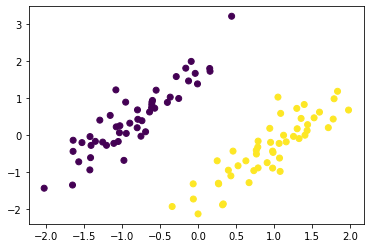

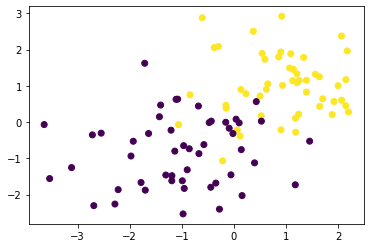

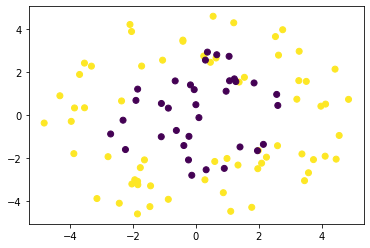

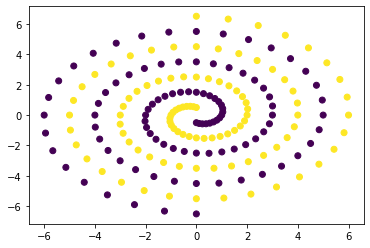

In [140]:
#Plotting the data
seed = 0 #0 means random, seed > 0 means fixed
np.random.seed(seed) if seed else None

d,t = syn1(100)
plt.figure(1)
plt.scatter(d[:,0],d[:,1], c=t)

d,t = syn2(100)
plt.figure(2)
plt.scatter(d[:,0],d[:,1], c=t)

d,t = syn3(100)
plt.figure(3)
plt.scatter(d[:,0],d[:,1], c=t)

d,t = spiral()
plt.figure(4)
plt.scatter(d[:,0],d[:,1], c=t)


In [141]:
def stats_class(x = None, y = None, label = 'Training', modl = None):
    """
    input :  
             x = input
             y = output
             label = "Provided text string"
             modl = the model
             
    output : 
             sensitivity = fraction of correctly classified positive cases
             specificity = fraction of correctly classified negative cases
             accuracy = fraction of correctly classified cases
             loss = typically the cross-entropy error
    """
    
    def binary(y1):
        y1[y1>.5] = 1.
        y1[y1<= .5] = 0.        
        return y1

    y_pr = modl.predict(x, batch_size = x.shape[0], verbose=0).reshape(y.shape)
                
    nof_p, tp, nof_n, tn = [np.count_nonzero(k) for k in [y==1, y_pr[y==1.] > 0.5, y==0, y_pr[y==0.]<= 0.5]]
    
    sens = tp / nof_p
    spec = tn / nof_n
    acc = (tp + tn) / (len(y))
    loss = modl.evaluate(x, y , batch_size =  x.shape[0], verbose=0)
                
    A = ['Accuracy', 'Sensitivity', 'Specificity', 'Loss']
    B = [acc, sens, spec, loss]
    
    print('\n','#'*10,'STATISTICS for {} Data'.format(label), '#'*10, '\n')
    for r in zip(A,B):
         print(*r, sep = '   ')
    return print('\n','#'*50)

def stats_reg(d = None, d_pred = None, label = 'Training', estimat = None):
    
    A = ['MSE', 'CorrCoeff']
    
    pcorr = np.corrcoef(d, d_pred)[1,0]
    
    if label.lower() in ['training', 'trn', 'train']:
        mse = estimat.history['loss'][-1]
    else:
        mse = estimat.history['val_loss'][-1] 

    B = [mse, pcorr]
    
    print('\n','#'*10,'STATISTICS for {} Data'.format(label), '#'*10, '\n')
    for r in zip(A,B):
         print(*r, sep = '   ')
    return print('\n','#'*50)



In [142]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()


In [143]:
def decision_b(X = None, Y1 = None ):
    
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    # grid stepsize
    h = 0.025

    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    Z[Z>.5] = 1
    Z[Z<= .5] = 0

    Y_pr = model.predict(X, batch_size = X.shape[0], verbose=0).reshape(Y1.shape)
  
    Y = np.copy(Y1)
    Y_pr[Y_pr>.5] = 1
    Y_pr[Y_pr<= .5] = 0
    Y[(Y!=Y_pr) & (Y==0)] = 2
    Y[(Y!=Y_pr) & (Y==1)] = 3
    
    
    plt.figure()
    #plt.contourf(xx, yy, Z, cmap=plt.cm.PRGn, alpha = .9) 
    plt.contour(xx, yy, Z, cmap=plt.cm.Paired)
    
    
    plt.scatter(X[:, 0][Y==1], X[:, 1][Y==1], marker='+', c='k')
    plt.scatter(X[:, 0][Y==0], X[:, 1][Y==0], marker='o', c='k')
       
    plt.scatter(X[:, 0][Y==3], X[:, 1][Y==3], marker = '+', c='r')   
    plt.scatter(X[:, 0][Y==2], X[:, 1][Y==2], marker = 'o', c='r')
    
    
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.tight_layout()


### CellName: Ex1 (#8)
### CellType: Exercise
### Cell instruction: Instruction for question 1

The cell below should be used for question 1. You can run the cell as it is (i.e. CTRL-Return). However, looking at the code will help you understand how the network is created, trained and evaluated. It will be useful for the other questions.

#### Question 1

Use synthetic data 1 (syn1) (100 data points) and train a linear MLP to separate the two classes, i.e. use a single hidden node. **Why can you solve this problem with a single hidden node?**


Model: "model_84"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 2)                 0         
_________________________________________________________________
dense_167 (Dense)            (None, 1)                 3         
_________________________________________________________________
dense_168 (Dense)            (None, 1)                 2         
Total params: 5
Trainable params: 5
Non-trainable params: 0
_________________________________________________________________

 ########## STATISTICS for Training Data ########## 

Accuracy   1.0
Sensitivity   1.0
Specificity   1.0
Loss   0.0029842155054211617

 ##################################################


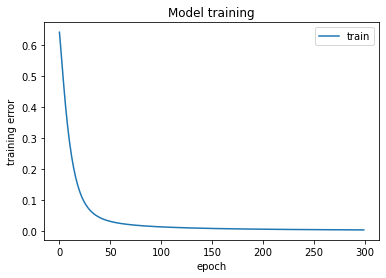

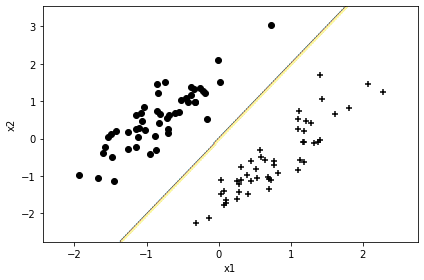

In [144]:
# seed = 0 means random, seed > 0 means fixed
seed = 0
np.random.seed(seed) if seed else None
    
# Generate training data
x_train, d_train = syn1(100)

# Define the network, cost function and minimization method
INPUT = {'inp_dim': x_train.shape[1],         
         'n_nod': [1],                      # number of nodes in hidden layer
         'act_fun': 'tanh',                 # activation functions for the hidden layer
         'out_act_fun': 'sigmoid',          # output activation function
         'opt_method': "Adam",               # minimization method
         'cost_fun': 'binary_crossentropy', # error function
         'lr_rate': 0.1,                    # learningrate
         'num_out' : 1 }              # if binary --> 1 |  regression--> num inputs | multi-class--> num of classes

# Get the model
model = pipline(**INPUT)

# Print a summary of the model
model.summary()

# Train the model
estimator = model.fit(x_train, d_train,
                      epochs = 300,                     # Number of epochs
                      #validation_data=(x_val, y_val),  # We don't have any validation dataset!
                      batch_size = x_train.shape[0],    # Use batch learning
                      #batch_size=25,                   
                      verbose = 0)

# Call the stats function to print out statistics for the training
stats_class(x_train, d_train, 'Training', model)

# Some plotting
plt.plot(estimator.history['loss'])
plt.title('Model training')
plt.ylabel('training error')
plt.xlabel('epoch')
plt.legend(['train'], loc=0)
plt.show()

# Show the decision boundary
decision_b(x_train, d_train)


### CellName: Ex2 (#9)
### CellType: Exercise
### Cell instruction: Instruction for question 2-5

The cell below should be used for questions 2-5. For question 2 you can run the cell as it is (i.e. CTRL-Return). For the other questions you need to modify the cell in order to change data set, vary the size of the network etc. There are brief comments in the code that will guide you here.

From now on we will talk about *performance*! It can be performance of a trained model on the training dataset or the performance on the validation dataset. What do we mean by performance?  For classification problems we will provide 4 different measurements as returned by a call to the *stats_class* function. They are:
* Sensitivity = fraction of correctly classified "1" cases
* Specificity = fraction of correctly classified "0" cases
* Accuracy = fraction of correctly classified cases
* loss = cross-entropy error (so low loss means good performance!)

Our suggestion for you is to either use accuracy or loss as your performance measure.

#### Question 2
Here you are going to train a classifier for the *syn2* dataset. You are also going to use a validation dataset as an estimate of the *true* performance. Since we generate these datasets we can allow for a relatively large validation dataset in order to get a more accurate estimation of *true* performance. The default value in the cell is to generate 1000 validation datapoints. 

Now, use synthetic data 2 (syn2)(100 training data points) and train a *linear* MLP to separate the two classes, i.e. use a single hidden node. **What is the performance you get on the validation dataset?** Note: Use a fixed random seed for this exercise since you will compare with runs in the next question.

#### Question 3
You are now going to overtrain the MLP! By increasing the number of hidden nodes we should be able to get better and better training performance. **How many hidden nodes do you need to reach an accuracy >95% on your training dataset?**

**Hint:** Overtraining here often means finding good local minimum of the error function, which may require some tuning of the learning parameters. This means that you may have to change the learning rate, increase the number of epochs and use "better" minimization methods. Even though we have not yet talked about the *Adam* minimization method, it is generally better than vanilla *stochastic gradient descent*. It is therefore used in the cells below as the default minimizer. Also you may want to change the size of the "batch_size" parameter. It is by default using all data.

#### Question 4
The effect of overtraining can be monitored by looking at the validation performance. **(a) When you overtrained in the previous question, how much much did the validation *loss* increase, compared to the linear model of Q2?** **(b) What is the optimal number of hidden nodes for the syn2 dataset in order to maximize your validation performance?** 

#### Question 5
Now you are going to use the *syn3* dataset. So, use **150** training datapoints from the synthetic dataset 3 and train an MLP to separate the two classes. Also use about 1000 datapoints for validation. **How many hidden nodes do you need to find a reasonable solution to the problem?  Extra: Can you figure out why this many?**


Model: "model_103"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 2)                 0         
_________________________________________________________________
dense_205 (Dense)            (None, 4)                 12        
_________________________________________________________________
dense_206 (Dense)            (None, 1)                 5         
Total params: 17
Trainable params: 17
Non-trainable params: 0
_________________________________________________________________

 ########## STATISTICS for Training Data ########## 

Accuracy   0.8066666666666666
Sensitivity   0.85
Specificity   0.72
Loss   0.3077183663845062

 ##################################################

 ########## STATISTICS for Validation Data ########## 

Accuracy   0.838
Sensitivity   0.8858858858858859
Specificity   0.7425149700598802
Loss   0.28880876302719116

 ####################

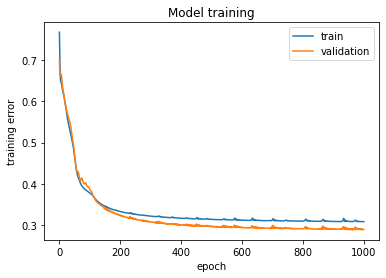

CPU times: user 41.3 s, sys: 1.92 s, total: 43.2 s
Wall time: 37.6 s


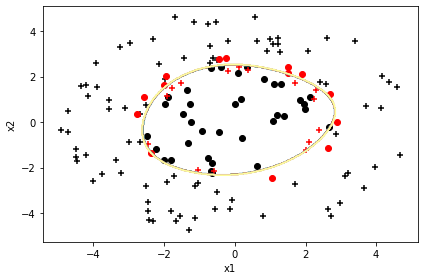

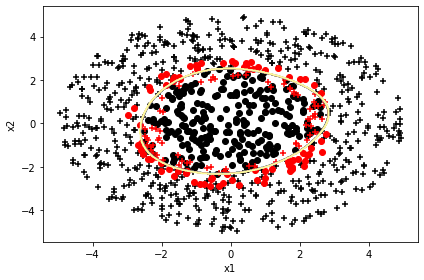

In [172]:
%%time
# seed = 0 means random, seed > 0 means fixed
seed = 3
np.random.seed(seed) if seed else None

# Generate training data
x_train, d_train = syn3(150)
x_val, d_val = syn3(1000)

# Define the network, cost function and minimization method
INPUT = {'inp_dim': x_train.shape[1],         
         'n_nod': [4],                      # number of nodes in hidden layer
         'act_fun': 'tanh',                 # activation functions for the hidden layer
         'out_act_fun': 'sigmoid',          # output activation function
         'opt_method': 'Adam',               # minimization method
         'cost_fun': 'binary_crossentropy', # error function
         'lr_rate': 0.07 ,                    # learningrate
         'num_out' : 1 }              # if binary --> 1 |  regression--> num inputs | multi-class--> num of classes

# Get the model
model = pipline(**INPUT)

# Print a summary of the model
model.summary()

# Train the model
estimator = model.fit(x_train, d_train,
                      epochs = 1000,      
                      validation_data=(x_val, d_val),
                      batch_size = x_train.shape[0],    # Batch size = all data (batch learning)
                      #batch_size=50,                   # Batch size for true SGD
                      verbose = 0)

# Call the stats function to print out statistics for classification problems
stats_class(x_train, d_train, 'Training', model)
stats_class(x_val, d_val, 'Validation', model)

# Plot the learning curves
plt.plot(estimator.history['loss'])
plt.plot(estimator.history['val_loss'])
plt.title('Model training')
plt.ylabel('training error')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc=0)
plt.show()

# Show the decision boundary for the training dataset
decision_b(x_train, d_train)

# If you uncomment this one you will see how the decsion boundary is with respect to the validation data
decision_b(x_val, d_val)



### CellName: Ex3 (#10)
### CellType: Exercise
### Cell instruction: Instruction for question 6-9

Now we are going to look at a regression problem. The data as described above (regr1) consists of 6 inputs (features) and one output (target) value. As for previous examples a new data set is generated each time you call the *regr1* function. To get exactly the same data set between different calls, use a fixed seed. New for this problem is that one can also control the amount of noise added to the target value. We are going to use a relatively small training dataset (~250) and a larger validation dataset (~1000) to get a more robust estimation of the generalization performance. For regression problems we also need new performance measures. The *stats_reg* function will give you two such measures:
* MSE = mean squared error (low error mean good performance)
* CorrCoeff = Pearson correlation coefficient for the scatter plot between predicted and true values.

The cell below can be used as an template for all questions regarding this regression problem.

#### Question 6
Use 250 data points for training and about 1000 for validation and **no** added noise. Train an MLP to predict the target output. If you increase the complexity of the model (e.g. number of hidden nodes) you should be able to reach a very small training error. You will also most likely see that the validation error decreases as you increase the complexity or at least no clear sign of overtraining. **Even though the validation error is most likely still larger than the training error why do we not see any overtraining of the model? (Hint: What is it that typically causes overfitting?)**

**Note:** As with previous examples you may need to tune the optimization parameters to make sure that you have "optimal" training. That is, increase or decrease the learningrate, possibly train longer times (increase *epochs*) and change the *batch_size* parameter.

#### Question 7
Use the same training and validation data sets as above, but add 0.4 units of noise (set the second parameter when calling the *regr1* function to 0.4 for both training and validation). Now train again, starting with a "small" model and increase the number of hidden nodes as you monitor the validation result for each model. **How many nodes do you have for opitimal validation performance, i.e. more hidden nodes results in overtraining?** Make a note of the validation error you obtained a this point!

#### Question 8
Instead of using the number of hidden nodes to control the complexity it is often better to use a regularization term added to the error function. You are now going to control the complexity by adding a *L2* regularizer (see the "INPUT" dictionary in the cell). You should modify this value until you find the "near optimal" validation performance. Use 15 hidden nodes. **Give the L2 value that you found to give "optimal" validation performance and compare with the result from  question 7 (optimal performance).**

#### Question 9 
**Summarize your findings in a few sentences.**


Model: "model_86"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 6)                 0         
_________________________________________________________________
dense_171 (Dense)            (None, 8)                 56        
_________________________________________________________________
dense_172 (Dense)            (None, 1)                 9         
Total params: 65
Trainable params: 65
Non-trainable params: 0
_________________________________________________________________

 ########## STATISTICS for Training Data ########## 

MSE   0.3388689637184143
CorrCoeff   0.8501589644387892

 ##################################################

 ########## STATISTICS for Validation Data ########## 

MSE   0.446095809340477
CorrCoeff   0.7909550118371629

 ##################################################


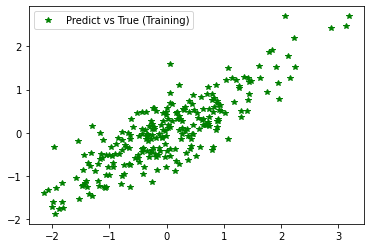

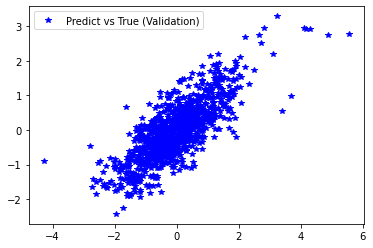

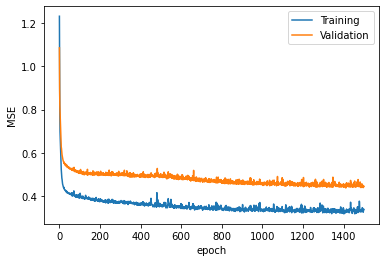

CPU times: user 1min 24s, sys: 6.05 s, total: 1min 30s
Wall time: 1min 5s


In [146]:
%%time
# seed = 0 means random, seed > 0 means fixed
seed = 10
np.random.seed(seed) if seed else None

# Generate training and validation data
x_train, d_train = regr1(250, 0.4) # 250 data points with no noise
x_val, d_val = regr1(1000, 0.4)

# Here we need to normalize the target values
norm_m = d_train.mean(axis=0)
norm_s = d_train.std(axis=0)
d_train = (d_train - norm_m) / norm_s

# We use the same normalization for the validation data.
d_val = (d_val - norm_m) / norm_s


# Define the network, cost function and minimization method
INPUT = {'inp_dim': x_train.shape[1],         
         'n_nod': [8],                      # number of nodes in hidden layer
         'act_fun': 'tanh',                 # activation functions for the hidden layer
         'out_act_fun': 'linear',           # output activation function
         'opt_method': 'Adam',               # minimization method
         'cost_fun': 'mse',                 # error function
         'lr_rate': 0.01,                   # learningrate
         'lambd' : 0.05,                    # L2
         'num_out' : 1 }   # if binary --> 1 |  regression--> num output | multi-class--> num of classes

# Get the model
model = pipline(**INPUT)

# Print a summary of the model
model.summary()

# Train the model
estimator = model.fit(x_train, 
                      d_train,
                      epochs = 1500,      # Number of epochs
                      validation_data=(x_val,d_val),
                      #batch_size = x_train.shape[0],   # Batch size = all data (batch learning)
                      batch_size=50,                    # Batch size for true SGD
                      verbose = 0)

# Call the stats function to print out statistics for classification problems
pred_trn = model.predict(x_train).reshape(d_train.shape)
pred_val = model.predict(x_val).reshape(d_val.shape)
stats_reg(d_train, pred_trn, 'Training', estimator)
stats_reg(d_val, pred_val, 'Validation', estimator)

# Scatter plots of predicted and true values
plt.figure()
plt.plot(d_train, pred_trn, 'g*', label='Predict vs True (Training)')
plt.legend()
plt.figure()
plt.plot(d_val, pred_val, 'b*', label='Predict vs True (Validation)')
plt.legend()
plt.show()

# Plot the learning curves
plt.figure()
plt.plot(estimator.history['loss'], label='Training')
plt.plot(estimator.history['val_loss'], label='Validation')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend()
plt.show()


### CellName: Ex4 (#11)
### CellType: Exercise
### Cell instruction: Instruction for question 10

For this exercise you are given a classification problem with a fixed training-, validation- and test dataset. The data is the Japanse vowels dataset described in the first cell. Your task is to do model selection, coming up with your optimal MLP architecture together with the hyperparameters you used. We do not provide any python code for this question, only the small part that reads the data (next code cell). There is an additional code cell that can be used to print the confusion matrix for the test data (see comments within that cell). (You can modify this function if you want to compute this matrix for both training and validation.)

#### Question 10
**Present an MLP with associated hyperparameters that maximizes the validation performance and give the test performance you obtained.**

**Hint 1:** 
Remember to check if input data needs to be normalized. See the "Ex3" cell how this was done (in that case for the target data).

**Hint 2:** 
This problem is a 9-class classification problem, meaning that you should use a specific output activation function (*out_act_fun*) and a specific loss/error function (*cost_fun*).

**Hint 3:**
The function *stats_class* function does not work here since it is designed for binary classification problems.


In [162]:
%%time
# seed = 0 means random, seed > 0 means fixed
seed = 0
np.random.seed(seed) if seed else None

x_train, y_train, x_val, y_val, x_test, y_test = vowels()
num_classes = 9

print('train input size: ',x_train.shape, 'train target size: ',y_train.shape)
print('val   input size: ',x_val.shape, 'val   target size: ',y_val.shape)
print('test  input size: ',x_test.shape, 'test  target size: ',y_test.shape)

"""# Here we need to normalize the target values
norm_m = d_train.mean(axis=0)
norm_s = d_train.std(axis=0)
d_train = (d_train - norm_m) / norm_s"""

# Define the network, cost function and minimization method
INPUT = {'inp_dim': x_train.shape[1],         
         'n_nod': [10],                      # number of nodes in hidden layer
         'act_fun': 'tanh',                 # activation functions for the hidden layer
         'out_act_fun': 'softmax',           # output activation function
         'opt_method': 'Adam',               # minimization method
         'cost_fun': 'categorical_crossentropy',                 # error function
         'lr_rate': 0.001,                   # learningrate
         'lambd' : 0.001,                    # L2
         'num_out' : num_classes }   # if binary --> 1 |  regression--> num output | multi-class--> num of classes

# Get the model
model_vowels = pipline(**INPUT)

# Print a summary of the model
model_vowels.summary()

# Train the model
estimator = model_vowels.fit(x_train, 
                      y_train,
                      epochs = 500,      # Number of epochs
                      validation_data=(x_val,y_val),
                      #batch_size = x_train.shape[0],   # Batch size = all data (batch learning)
                      batch_size=50,                    # Batch size for true SGD
                      verbose = 0)


train input size:  (4274, 12) train target size:  (4274, 9)
val   input size:  (2275, 12) val   target size:  (2275, 9)
test  input size:  (3412, 12) test  target size:  (3412, 9)
Model: "model_94"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 12)                0         
_________________________________________________________________
dense_187 (Dense)            (None, 10)                130       
_________________________________________________________________
dense_188 (Dense)            (None, 9)                 99        
Total params: 229
Trainable params: 229
Non-trainable params: 0
_________________________________________________________________
CPU times: user 3min 23s, sys: 18.6 s, total: 3min 42s
Wall time: 2min 13s



 ########## Result for Test Data ########## 

log_loss:    0.25234911038846913
accuracy:    0.9196951934349356 

              precision    recall  f1-score   support

     class 1       0.94      0.95      0.94       303
     class 2       0.85      0.86      0.86       322
     class 3       0.93      0.94      0.94       708
     class 4       0.95      0.91      0.93       528
     class 5       0.93      0.92      0.92       247
     class 6       0.96      1.00      0.98       265
     class 7       0.98      0.95      0.97       400
     class 8       0.84      0.82      0.83       384
     class 9       0.84      0.92      0.88       255

    accuracy                           0.92      3412
   macro avg       0.92      0.92      0.92      3412
weighted avg       0.92      0.92      0.92      3412



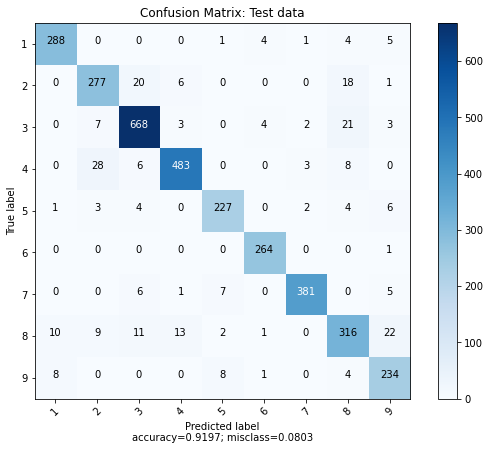

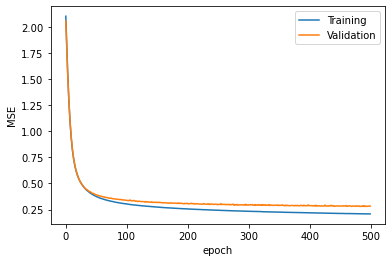

In [163]:
"""
This cell can be used to present the classification results. 
It assumes you trained model has the name 'model_vowels'. 
It shows the test data results, but it can be changed to show
the training/validation.
"""
print('\n','#'*10,'Result for {} Data'.format('Test'), '#'*10, '\n')

y_pred = model_vowels.predict(x_test, verbose=0 )
print('log_loss:   ', log_loss(y_test, y_pred, eps=1e-15))

y_true = y_test.argmax(axis=1)
y_pred = y_pred.argmax(axis=1)
print('accuracy:   ',(y_pred==y_true).mean(), '\n')

target_names = ['class {}'.format(i+1) for i in range(9)]
print(classification_report(y_true, y_pred, target_names=target_names))

confuTst = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm           = confuTst, 
                      normalize    = False,
                      target_names = ['1', '2', '3', '4', '5', '6','7', '8','9'],
                      title        = "Confusion Matrix: Test data")

# Plot the learning curves
plt.figure()
plt.plot(estimator.history['loss'], label='Training')
plt.plot(estimator.history['val_loss'], label='Validation')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend()
plt.show()

### CellName: Ex5 (#12)
### CellType: Exercise
### Cell instruction: Instruction for question 11

For this last exercise the task is to train a binary classifier for the spiral problem. The aim is to get *zero* classification error for the training data (there is no test data) with as small as possible model, in terms of the number of trainable weights. Also plot the boundary to see if it resembles a spriral. To pass this question you should at least try!

#### Question 11
**Train a classifier for the spiral problem with the aim of zero classification error with as small as possible model.**

In [230]:
%%time
# seed = 0 means random, seed > 0 means fixed
seed = 3
np.random.seed(seed) if seed else None

# Generate training data
x_train, d_train = spiral()
x_train = x_train / 5

# Define the network, cost function and minimization method
INPUT = {'inp_dim': x_train.shape[1],         
         'n_nod': [1000],                      # number of nodes in hidden layer
         'act_fun': 'relu',                 # activation functions for the hidden layer
         'out_act_fun': 'relu',          # output activation function
         'opt_method': 'Adam',               # minimization method
         'cost_fun': 'binary_crossentropy', # error function
         'lr_rate': 0.001 ,                    # learningrate
         'num_out' : 1 }              # if binary --> 1 |  regression--> num inputs | multi-class--> num of classes

# Get the model
model = pipline(**INPUT)

# Print a summary of the model
#model.summary()

# Train the model
estimator = model.fit(x_train, d_train,
                      epochs = 1000,      
                      batch_size = x_train.shape[0],    # Batch size = all data (batch learning)
                      #batch_size=50,                   # Batch size for true SGD
                      verbose = 0)


CPU times: user 18.7 s, sys: 1.11 s, total: 19.8 s
Wall time: 12.9 s



 ########## STATISTICS for Training Data ########## 

Accuracy   0.5618556701030928
Sensitivity   0.5670103092783505
Specificity   0.5567010309278351
Loss   0.6722643375396729

 ##################################################


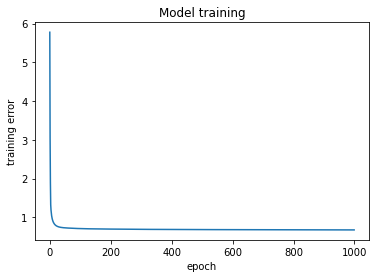

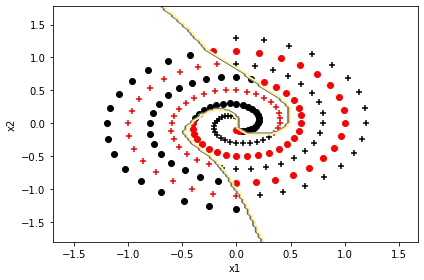

In [231]:
# Call the stats function to print out statistics for classification problems
stats_class(x_train, d_train, 'Training', model)

# Plot the learning curves
plt.plot(estimator.history['loss'])
plt.title('Model training')
plt.ylabel('training error')
plt.xlabel('epoch')
plt.show()

# Show the decision boundary for the training dataset
decision_b(x_train, d_train)

# The report!


### Name
Mandus Hjelm 

### Introduction

This lab is about trying the different ways to tune the parameters when building a MLP. I had to change the pipfunction to work but I guess that is okey.   

### Answers to questions
**Question 1:** Since there is a linear solution to the problem as can be seen in the second picture a single node is able to produce that line that seperate the clusters. 

**Question 2:** Accuracy   0.875
Sensitivity   0.904
Specificity   0.846
Loss   0.29202935099601746

**Question 3:**
When increasing the number of nodes to 7 the accuracy on the trainingset is 0.96.

**Question 4:**
Accuracy   0.828
Sensitivity   0.836
Specificity   0.82
Loss   1.4628673791885376
**a:** 1.4628673791885376-0.29202935099601746= 1.17083802819
**b:** Since the validation loss is increasingn when increasing the nodes the best number of nodes is 1. 

**Question 5:**
The best number of nodes with the other dataset is 3. 

**Question 6:**
A model is prone to overfit when the complexity of the model is increasing and then totaly fit the training dataset. But since the training data and validation data is to similair the overfit doesn´t cause a problem/can not be seen 

**Question 7:**
When adding noice to the data this the similarity in the dataset are reduced and therefor the overfit problem is observable with a result of complex models not perform as good as a more simple model. I find the best number of nodes with a learning_rate of 0.01, and 1500 epochs are 11. With a MSE 0.38246624991297723 and CorrCoeff 0.8128445971225537

**Question 8:**
With L2= 0.01 I get a MSE   0.4341416865587234 CorrCoeff   0.7912590764461892 so I get a worse result than just adjusting the hiden nodes. 

**Question 9:**
The develop the optimal model there is a lot of parameters like how much regulazation, how many nodes etc. To be able to evaluate the model the accuracy is not the only tool aswell can the cross-entropy error be useful. 

**Question 10:**         
         'n_nod': [10],                    
         'act_fun': 'tanh',               
         'out_act_fun': 'softmax',           
         'opt_method': 'Adam',             
         'cost_fun': 'mse',                 
         'lr_rate': 0.001,                   
         'lambd' : 0.001, 
         epochs : 500
        
log_loss:    0.25234911
accuracy:    0.91969519

### Summary

Previously I have builded the layers and specified each layers activation function and so on, so this was another aproch. Most intresting in this aproach I would say is the importance of number of nodes. My first thought was that more nodes the better but in this lab that statment was proven wrong. 
  